### Overview
This notebook imports the **query** (an unannotated scRNA-seq, publicly available dataset [2]), extracts the data and convert them into CSV for the next annotation step (scmap or SCINA). 

### Steps performed

##### Import and inspect the query dataset
1. Import the query (assigned to que_annotation)
2. Check if the data is in raw counts format
3. Visualize the top 25 expressed genes
4. Visualize the PCA on the data, and to get the number of principle components (n_pcs)
5. Visualize the UMAP of the data, colored by annotated cell-type

##### Standardize and log-transform the dataset
6. Normalize and log-transform the data

##### Export the data:
7. Export the data in 3 separate files in CSV:
- expression matrix (transposed to meet R's requirement), 
- gene names, 
- cell ID 

##### Calculate the highly expressed genes (HVG)
8. Reimport the reference as the HVG calculation (Seurat_v3) works with raw count
9. Calculate the HVG

##### Export the HVG:
10. Export the HVG in CSV

In [1]:
#Libraries and random state
import scanpy as sc
import pandas as pd
%matplotlib inline 

i_randomstate=4 #for reproducibility

#### Import unannotated pre-processed scRNA-seq and visualize the data

In [2]:
#Import unannotated scRNA-seq
input_path ="../../data/demo_public/input/AllenBrain_unannotated.h5ad"
que_annotation = sc.read(input_path, cache=True)
que_annotation

AnnData object with n_obs × n_vars = 4053 × 31053
    obs: 'Allen_celltype', 'Allen_sampleID'

In [3]:
#Check data 
que_annotation.X

array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [15.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [4]:
#Take a look at the list of samples in the dataset
que_annotation.obs["Allen_sampleID"].unique().tolist()

[446701, 410108, 410107]

In [5]:
#Convert Allen_sampleID from int to string
que_annotation.obs["Allen_sampleID"] = que_annotation.obs["Allen_sampleID"].astype(str)
que_annotation.obs["Allen_sampleID"].unique().tolist()

['446701', '410108', '410107']

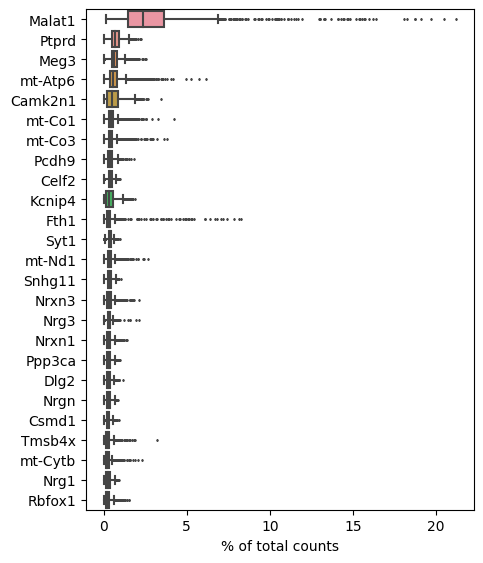

In [6]:
#Visualize the highest expressed genes
sc.pl.highest_expr_genes(que_annotation, n_top=25)

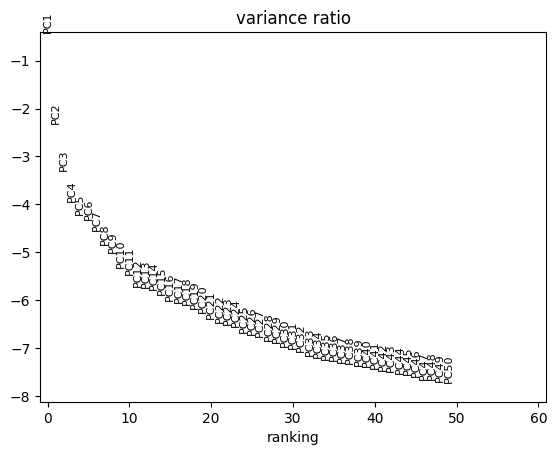

In [7]:
#Visualize the PCA on the data
sc.tl.pca(que_annotation, svd_solver='arpack')
sc.pl.pca_variance_ratio(que_annotation, log=True, n_pcs=60)

/home/chiacmm/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


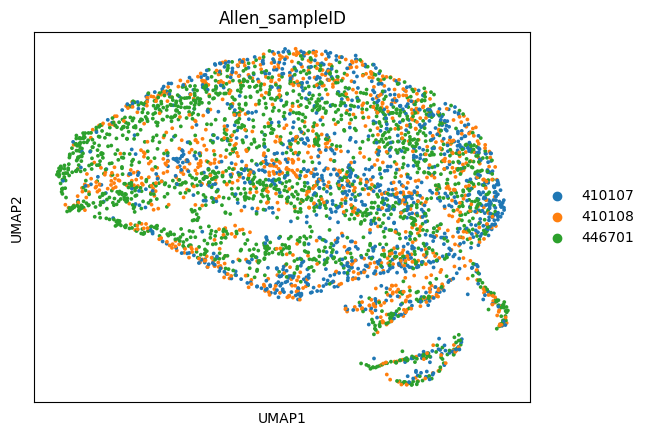

In [8]:
#Visualizing clustering of data per sample ID. Note that this dataset has been preprocessed and the outlying sample(s) was removed.
sc.pp.neighbors(que_annotation, n_neighbors=50, n_pcs=40, random_state=i_randomstate)
sc.tl.umap(que_annotation, min_dist=0.4, random_state=i_randomstate)
sc.pl.umap(que_annotation, color="Allen_sampleID")

##### Standardize and log-transform the dataset

In [9]:
#Standardization and log-transformation
sc.pp.normalize_total(que_annotation, exclude_highly_expressed=True, max_fraction=0.2, inplace=True)
sc.pp.log1p(que_annotation)

In [10]:
#Check data 
que_annotation.X

array([[1.3111639 , 1.3111639 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.4906006 , 0.6205444 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [2.2904706 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.055182  , 0.        , 0.        , ..., 0.85936135, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

#### Export the data

In [11]:
#Write reference annotation to CSV

#Get expression matrix, gene names, cell_ID and celltype
d_exprs = que_annotation.X
l_genes = que_annotation.var_names.tolist()
l_cellID = que_annotation.obs_names.tolist()


#Create dataframe without index column and column names
df_genes = pd.DataFrame(l_genes)
df_cellID = pd.DataFrame(l_cellID)
df_exprs = pd.DataFrame(d_exprs)

#Transpose to get columns = cells, rows = genes
df_exprs = df_exprs.transpose()


#Write data
path = "../../data/demo_public/output/que_lgenes.csv"
df_genes.to_csv(path, sep=',', index=False)

path = "../../data/demo_public/output/que_lcellID.csv"
df_cellID.to_csv(path, sep=',', index=False)

path = "../../data/demo_public/output/que_exprs.csv"
df_exprs.to_csv(path, sep=',', index=False)

##### Calculate Highly variable genes (HVG)

In [12]:
#Re-import annotated scRNA-seq (reference for annotation) for hvg calculation
que_hvg = sc.read(input_path, cache=True)
que_hvg

AnnData object with n_obs × n_vars = 4053 × 31053
    obs: 'Allen_celltype', 'Allen_sampleID'

In [13]:
#Calculate highly variable genes
sc.pp.highly_variable_genes(que_hvg, flavor='seurat_v3', n_top_genes=2000, inplace=True) 
que_hvg

AnnData object with n_obs × n_vars = 4053 × 31053
    obs: 'Allen_celltype', 'Allen_sampleID'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

#### Export the HVG in CSV

In [14]:
#Write to CSV
l_hvg_genes = que_hvg.var_names[que_hvg.var["highly_variable"]==True].tolist()

#Create dataframe
df_hvggenes = pd.DataFrame(l_hvg_genes)

#Write data
path = "../../data/demo_public/output/que_l_hvg_genes.csv"
df_hvggenes.to_csv(path, sep=',', index=False)

#### References
1. Chia, C. M., Roig Adam, A., & Moro, A. (2022). *In silico* multiple single-subject neural tissue screening using deconvolution on pseudo-bulk RNA-seq - a prototype. Bioinformatics and Systems Biology joint degree program. Vrije Universiteit Amsterdam and University of Amsterdam. 

2. Allen Institute for Brain Science (2004). Allen Mouse Brain Atlas, Mouse Whole Cortex and Hippocampus 10x. Available from mouse.brain-map.org. Allen Institute for Brain Science (2011).